In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import time
import random
import datetime
import os
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import Tensor
import functools
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
import torchvision
from model.drn import drn_d_54, drn_d_base
from model.CBAM import drn_d_CBAM
from model.resnet import ResNet50 as resnet
from model.efficientnet import *
from load_data import *
from optimizer import Ranger
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score,accuracy_score, precision_score,f1_score

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mkuhd043 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
In /home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is dep

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [3]:
from load_data import *

In [4]:
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
test_size = 0.2
valid_size = 0.3
train_size = 0.5
batch_size = 4
test_bs = 4
random.seed(time.time())

In [34]:
class Focal_Loss(_Loss):
    def __init__(self, alpha = 1 , gamma = 1 , logits = False, reduce = False, ignore_index=10000, from_logits=False):
        super(Focal_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.logits = logits
        self.reduce = reduce
        self.loss  = nn.BCELoss(weight = torch.Tensor([3.0, 1.0]).to(device))
    def forward(self, inputs, targets):
        #CE = F.cross_entropy(inputs, targets, weight = torch.Tensor([1.0, 4.0]).to(device), ignore_index=self.ignore_index)
        inputs = torch.sigmoid(inputs)
        #print(inputs.shape, targets.shape)
        CE = self.loss(inputs, targets)
        pt = torch.exp(-CE)
        F_loss = self.alpha * (1-pt)**self.gamma * CE

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

class Hswish(nn.Module):
    def forward(self, x):
        swish = F.relu6(x + 3 , inplace = True)
        return x* swish/6.

class conv_set(nn.Module):
    """docstring for conv_set"""
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding):
        super(conv_set, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_ch),
            Hswish()
            )
    def forward(self, x):
        out = self.conv(x)
        return out

class A_net(nn.Module):

    def __init__(self, classes):
        super(A_net, self).__init__()
        self.classes = classes
        self.conv  = nn.Conv2d(1, 3, 1, 1, 0)
        self.conv1 = conv_set(3,12,3,1,0)
        self.conv2 = conv_set(12,16,3,1,0)
        self.conv3 = conv_set(16,32,3,1,0)
        self.conv4 = conv_set(32,classes,3,1,2)
        #self.conv5 = conv_set(64,classes,3,1,0)
    def forward(self, x):
        x = self.conv(x)
        out = self.conv1(x)
        out = F.max_pool2d(out, 2,2)
        out = self.conv2(out)
        out = F.max_pool2d(out, 2,2)
        out = self.conv3(out)
        out = F.max_pool2d(out, 2,2)
        out = self.conv4(out)
        return out 
    
class CNNX1(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(CNNX1, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model = drn_d_CBAM(nn.BatchNorm2d)
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = self._dropout(x)

        return x

class EFFN(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(EFFN, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        #self.model = drn_d_CBAM(nn.BatchNorm2d)
        self.model = efficientnet_el()
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        #x = self.fc(x)
        #x = self._dropout(x)

        return x
    
class CNNX(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(CNNX, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.model = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model = resnet()
        #self.model = drn_d_CBAM(nn.BatchNorm2d)
        self.attention = A_net(400)
        self.conv_out = nn.Conv2d(512,2,1)
        self.maxpool = nn.MaxPool2d(1)
        self._dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
        #atten = self.attention(input)
        #atten = torch.sigmoid(atten)
        #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self._dropout(x)

        return x

        
class CNNX3(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 3):
        super(CNNX3, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model = resnet()
        #self.model = drn_d_CBAM(nn.BatchNorm2d)
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self._dropout(x)

        return x

def save_model(state,save_model_path,modelname):
    filename = os.path.join(save_model_path,modelname+'_'+str(state['epoch']+1)+'.pth')
    torch.save(state,filename)

def save_best(state,save_model_path,modelname):
    filename = os.path.join(save_model_path,modelname+'_'+'.pth')
    torch.save(state,filename)

def load_model(Net, optimizer, model_file):
    assert os.path.exists(model_file),'There is no model file from'+model_file
    checkpoint = torch.load(model_file)
    print('load', model_file)
    Net.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']+1
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return Net, optimizer, start_epoch

def train(model, data_loader, opt, loss, epoch,verbose = True):
    model.train()
    loss_avg = 0.0
    correct = 0
    for batch_idx, (data,target) in enumerate(data_loader):
        #print(data.shape)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss_avg = loss_avg + loss.item()
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        target = target[:,1].long()
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        verbose_step = len(data_loader) 
        if (batch_idx+1)  % verbose_step == 0 and verbose:
            print('Train Epoch: {}  Step [{}/{} ({:.0f}%)]  Loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch, batch_idx * len(data), len(train_idx),
                100. * batch_idx / len(train_idx), loss.item(), correct, len(train_idx),
            100. * correct / (len(train_idx))))
    return loss_avg / (len(train_idx))

def test(model, data_loader, loss):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        correct_pe = 0
        correct_wnl = 0
        correct_noPE = 0
        y = []
        y_score = []
        y_pred = []
        y_score = []
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            #print(target.shape)
            output = model(data)
            test_loss += loss_fn(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            #print(pred)
            target = target[:,1].long()
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            score = F.softmax(output, dim = 1)
            for i in range(target.shape[0]):
                y.append(target[i].cpu().numpy())
                y_score.append(score[i,1].cpu().numpy())
                y_pred.append(pred[i].cpu().numpy())
                
                if target[i] == 2:
                    correct_noPE += pred[i].eq(target[i].data.view_as(pred[i])).cpu().sum().item()
                
                if target[i] == 1:
                    correct_pe += pred[i].eq(target[i].data.view_as(pred[i])).cpu().sum().item()
    
                if target[i] == 0:
                    correct_wnl += pred[i].eq(target[i].data.view_as(pred[i])).cpu().sum().item()

        test_loss /= len(data_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), PE_acc: ({}), wnl_acc: ({}), noPE_acc: ({})\n'.format(
            test_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset), correct_pe, correct_wnl, correct_noPE))   
    #return float(correct) / len(data_loader.dataset),y, y_score, y_pred
    return float(correct) / len(data_loader.dataset)


net = CNNX3().to(device)

class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
    Reference:
    Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    Code imported from https://github.com/Cysu/open-reid/blob/master/reid/loss/triplet.py.
    Args:
        margin (float): margin for triplet.
    """

    def __init__(self, margin=0.6, mutual_flag=False):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)
        self.mutual = mutual_flag

    def forward(self, inputs, targets):
        """
        Args:
            inputs: feature matrix with shape (batch_size, feat_dim)
            targets: ground truth labels with shape (num_classes)
        """
        n = inputs.size(0)
        # inputs = 1. * inputs / (torch.norm(inputs, 2, dim=-1, keepdim=True).expand_as(inputs) + 1e-12)
        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        # For each anchor, find the hardest positive and negative
        targets = targets[:,1]
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        loss = self.ranking_loss(dist_an, dist_ap, y)
        if self.mutual:
            return loss, dist
        return loss

class remix_loss(nn.Module):
    """docstring for remix_loss"""
    def __init__(self):
        super(remix_loss, self).__init__()
        self.loss1 = Focal_Loss()
        self.loss2 = TripletLoss()
    def forward(self, inputs, targets):
        loss = self.loss1(inputs, targets) + self.loss2(inputs, np.argmax(targets))

        return loss 

## Data process

In [7]:
import glob

folder_name =list(glob.glob('/home/ubuntu/Andrew/lung_datatset/'))
print(folder_name)
num_pic_1 = len(list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE/*'))+list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*')))
num_pic_0 = len(list(glob.glob('/home/ubuntu/Andrew/lung_datatset/WNL/*')))
print(num_pic_0,num_pic_1)

['/home/ubuntu/Andrew/lung_datatset/']
1882 822


In [16]:
CT_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/WNL/*'))
CT_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE/*'))
CT_2 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*'))
num_0 = len(CT_0)
num_1 = len(CT_1)
num_2 = len(CT_2)
print(num_0,num_1,num_2)

1882 167 655


In [17]:
random.shuffle(CT_0)
random.shuffle(CT_1)
random.shuffle(CT_2)
split_t_0 = int(train_size*500)
split_t_1 = int(train_size*num_1)
split_t_2 = int(train_size*num_2)
split_v_0 = int(valid_size*500)
split_v_1 = int(valid_size*num_1)
split_v_2 = int(valid_size*num_2)
print(split_t_0,split_t_1,split_v_0,split_v_1)
train_0 = CT_0[0:split_t_0]
train_1 = CT_1[0:split_t_1]
train_2 = CT_2[0:split_t_2]
valid_0 = CT_0[split_t_0:split_t_0+split_v_0]
valid_1 = CT_1[split_t_1:split_t_1+split_v_1]
valid_2 = CT_2[split_t_2:split_t_2+split_v_2]
test_0 = CT_0[split_t_0+split_v_0:]
test_1 = CT_1[split_t_1+split_v_1:]
test_2 = CT_2[split_t_2+split_v_2:]
print(len(train_0),len(train_1),len(valid_0),len(valid_1),len(test_0),len(test_1))

250 83 150 50
250 83 150 50 1482 34


In [57]:
def get_data(folder0, folder1, folder2, repeat):
    class0_path = []
    class1_path = []
    class2_path = []
    target0 = []
    target1 = []
    target2 = []
    for x in folder0:
        #print(x)
        class0 = x
        #print(class0)
        class0_path.append(class0)
        target0.append(torch.tensor([1.0,0.0, 0.0]).long())
    
    for x in folder1:
        #class1 = glob.glob(x + '/*dcm')
        class1 = x
        class1_path.append(class1)
        target1.append(torch.tensor([0.0,1.0, 0.0]).long())
    
    for x in folder2:
        #class1 = glob.glob(x + '/*dcm')
        class2 = x
        class2_path.append(class2)
        target2.append(torch.tensor([0.0,0.0,1.0]).long())
    #class0_path = random.sample(class0_path, k = len(class1_path))
    #target0 = random.sample(target0, k = len(target1))
    print(len(class0_path), len(class1_path), len(class2_path))
    file_path = class0_path + class1_path + class2_path
    target = target0 + target1 + target2
    #print(file_path, target)
    data = zip(file_path, target)
    return data, len(class0_path), len(class1_path), len(class2_path)

In [58]:
train_data, _, _, _ = get_data(train_0, train_1, train_2, 1)
valid_data,pe0, pe1, pe2 = get_data(valid_0, valid_1, valid_2, 1)
test_data, _, _,_ = get_data(test_0, test_1, test_2, 1)

250 83 327
150 50 196
1482 34 132


In [59]:
print(type(train_data))

<class 'zip'>


In [60]:
Train_Set = PE_transform(list(train_data), transform = None)
Valid_Set = PE_transform(list(valid_data), transform = None)
Test_Set = PE_transform(list(test_data), transform = None)

In [61]:
num_train = len(list(Train_Set))
num_valid = len(list(Valid_Set))
indices = list(range(num_train))
v_indices = list(range(num_valid))
train_idx, valid_idx = indices, v_indices

In [62]:
train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
                        num_workers=8, pin_memory=True)
valid_loader = DataLoader(Valid_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)
test_loader = DataLoader(Test_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

In [63]:
learning_rate = 0.0001
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
optimizer = Ranger(net.parameters())

# Train the model
num_epochs = 250
#model_name = 'resnet50'
model_name = 'class_3_0615'
#loss_fn = nn.BCELoss()
loss_fn = Focal_Loss()
output_path = 'log'
resume = 'None'

#resume = '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_a_.pth'
#resume = '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_.pth'
StartTime = time.time()
loss, val_acc, lr_curve = [], [], []
'''
if resume is not None:
    net, optimizer, _ = load_model(net, optimizer, resume)
    #print('load', resume)
'''

best_acc = 0.0
best = 0
for epoch in range(num_epochs):

    
    #if (epoch+1)%5 == 0:
    #    random.seed(epoch)
    #    train_data = get_train_data(train_folder)
    #    Train_Set = PE(list(train_data), transform = None)
    #    train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
    #                    num_workers=8, pin_memory=True)
    #    class0_path = random.sample(class0_path, k = 3*len(class1_path))
    #    target0 = random.sample(target0, k = 3*len(target1))
    #    print(len(class0_path), len(class1_path))
    #    file_path = class0_path + class1_path
    #    target = target0 + target1
    #    #print(file_path, target)
    #    train_data = zip(file_path, target)
    #    Train_Set = PE(list(train_data), transform = True)
    #    train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
    #                    num_workers=4, pin_memory=True)
    #lr = adjust_learning_rate(learning_rate, optimizer, epoch, epoch_list=[80, 170])
    train_loss = train(net, train_loader, optimizer, loss_fn, epoch, verbose=True)
    valid_acc = test(net, valid_loader, loss_fn)
    #valid_acc, tp, tn = test(net, valid_loader, loss_fn)
    loss.append(train_loss)
    #print((tn/pe0), tp/pe1)
    val_acc.append(valid_acc)
    if (epoch+1)%10 == 0 or epoch==num_epochs-1:
        save_model({'epoch':epoch,
                    'model_state_dict':net.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    },
                    os.path.join(output_path,'savemodel'),model_name)
    
    #if tp/pe1 > 0.7 and tn>best:
    if valid_acc >= best_acc:
        #print((tn//pe0), tp//pe1)
        print(valid_acc)
        save_best({'epoch':epoch,
                    'model_state_dict':net.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    },
                    os.path.join(output_path,'savemodel'),'CT_class_0615_tri')
        best_acc = valid_acc
        #best = tn
    

ValueError: Target and input must have the same number of elements. target nelement (12) != input nelement (8)

## ResNet 50 (50epoch) 

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_.pth

Test set: Average loss: 0.0796, Accuracy: 493/542 (91%), PE_acc: (138), normal_acc: (355)

Time Usage:  0:22:56


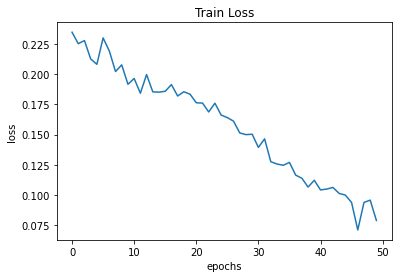

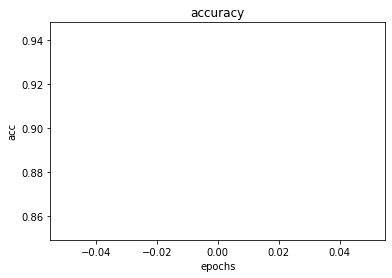

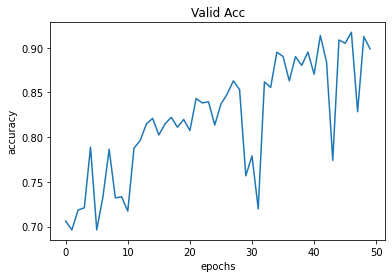

In [32]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_.pth')
test_acc = test(net, test_loader, loss_fn)
'''
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_A1_.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_10.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_20.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_30.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_40.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_50.pth')
test_acc = test(net, test_loader, loss_fn)
#test_acc, y, y_score, y_pred = test(net, test_loader, loss_fn)

y = np.array(y)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
print('precision', precision, 'recall', recall)
ftr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(ftr, tpr)
print('auc', roc_auc)
'''
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## ResNet 50 (250 epoch)

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_1_.pth

Test set: Average loss: 0.0711, Accuracy: 507/542 (94%), PE_acc: (143), normal_acc: (364)

Time Usage:  1:49:48


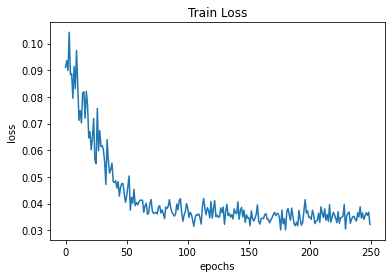

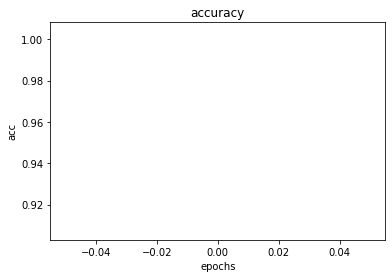

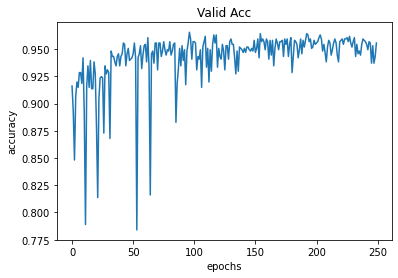

In [35]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_1_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DRN 150 epoch

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_a_.pth

Test set: Average loss: 0.0673, Accuracy: 503/542 (93%), PE_acc: (140), normal_acc: (363)

Time Usage:  4:19:26


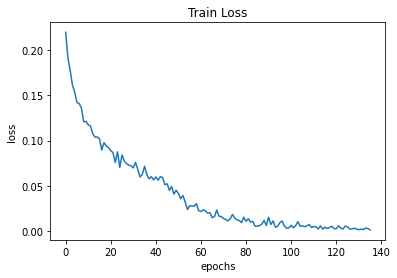

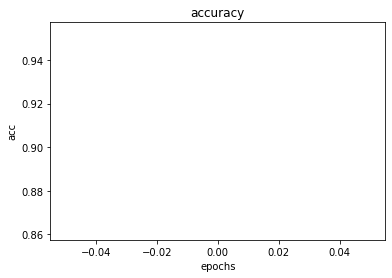

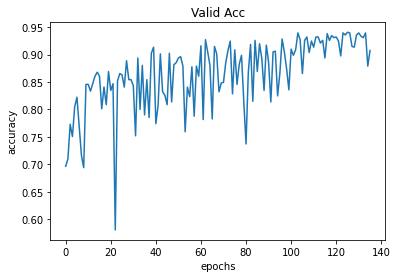

In [46]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_a_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DRN 250 epoch

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_.pth

Test set: Average loss: 0.0844, Accuracy: 481/542 (89%), PE_acc: (136), normal_acc: (345)

Time Usage:  8:10:43


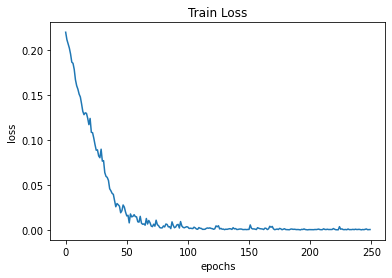

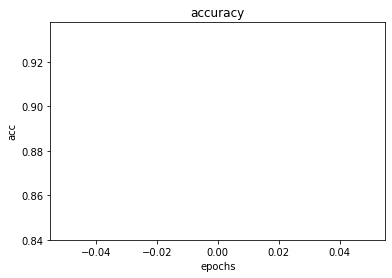

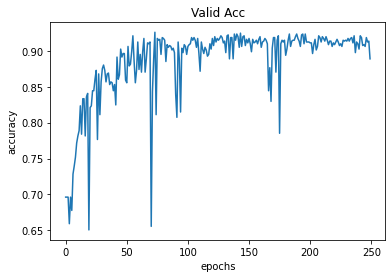

In [63]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DRN 250 epoch ranger

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_ranger_.pth
set state called

Test set: Average loss: 0.1052, Accuracy: 504/542 (93%), PE_acc: (139), normal_acc: (365)

Time Usage:  16:47:31


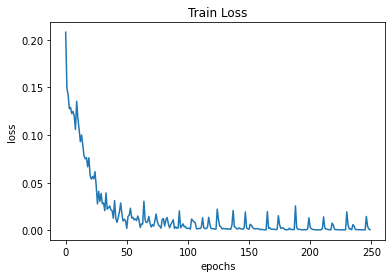

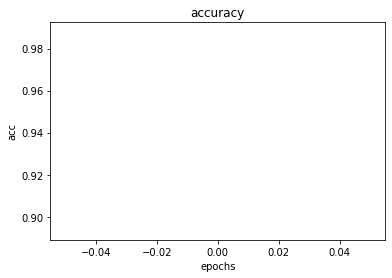

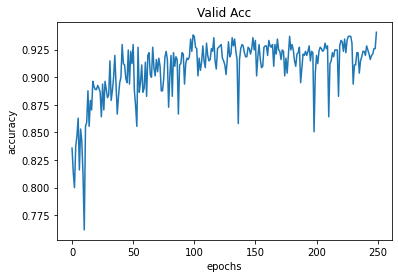

In [66]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_ranger_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## EfficientNet V3

In [18]:
optimizer = Ranger(net.parameters())
loss_fn = Focal_Loss()
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0608_eff_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0608_eff_.pth
set state called

Test set: Average loss: 0.0486, Accuracy: 506/542 (93%), PE_acc: (141), normal_acc: (365)



NameError: name 'StartTime' is not defined

In [20]:
 torch.cuda.empty_cache()

In [ ]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v0/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v1/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

NEW_dataset/20210604

In [ ]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/WNL/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
loss_fn = Focal_Loss()

In [ ]:
#net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_A1_.pth')
#testing_acc = test(net, testing_loader, loss_fn)

net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_10.pth')
testing_acc = test(net, testing_loader, loss_fn)
'''
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_20.pth')
testing_acc = test(net, testing_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_30.pth')
testing_acc = test(net, testing_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_40.pth')
testing_acc = test(net, testing_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_50.pth')
testing_acc = test(net, testing_loader, loss_fn)
'''